### Tasks
1. Train a small GAN on the MNIST dataset using PyTorch  
https://medium.com/intel-student-ambassadors/mnist-gan-detailed-step-by-step-explanation-implementation-in-code-ecc93b22dc60

2. Next, modify your code to train a second model on the EMNIST dataset. 
3. Freeze the weights of some layers of the trained model and fine-tune it on the MNIST dataset. 
4. Inspect and compare visual results as well as the losses during training. 
5. Summarize your results and conclusions. What other approaches could you come up with?

### Download Data

In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# Load training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

In [2]:
# Creating dataloaders

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

### Visualize a single element in Dataset

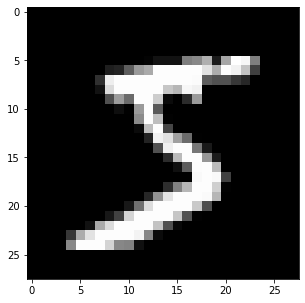

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

### Creating Discriminator Model

In [27]:
import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Discriminator, self).__init__()
        
        # define hidden linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim*4)
        self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)
        
        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim, output_size)
        
        # dropout layer 
        self.dropout = nn.Dropout(0.3)
        
        
    def forward(self, x):
        # flatten image
        x = x.view(-1, 28*28)
        # all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        # final layer
        out = self.fc4(x)

        return out

### Creating Generator Model

In [53]:
class Generator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()
        
        # define hidden linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
        
        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim*4, output_size)
        
        # dropout layer 
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        # final layer with tanh applied
        out = torch.tanh(self.fc4(x))

        return out

### Hyper Parametres for Discriminator and Generator

In [54]:
# Discriminator hyperparams
# 28*28
input_size = 784
# Size of discriminator output (real or fake)
d_output_size = 1
# Hidden layer size and multiple of the below size 
d_hidden_size = 32

# Generator hyperparams
# latent vecto size
z_size = 100
# Generated image size - same as input image size
g_output_size = 784
# Hidden layer size and multiple of the below size
g_hidden_size = 32

### Creating object of both Generator and Discriminator

In [55]:
D = Discriminator(input_size, d_hidden_size, d_output_size)
G = Generator(z_size, g_hidden_size, g_output_size)

# check that they are as you expect
print(D)
print(G)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)
Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [56]:
# print fc2 weight
print('fc2 weight before train:')
print(G.fc2.weight)

fc2 weight before train:
Parameter containing:
tensor([[-0.1074, -0.0509, -0.0067,  ..., -0.0324, -0.0522,  0.0773],
        [ 0.1554, -0.0486, -0.1466,  ...,  0.0800, -0.1663, -0.1678],
        [-0.0722,  0.0463, -0.1254,  ..., -0.0456,  0.0122, -0.0489],
        ...,
        [-0.0394,  0.0905,  0.0489,  ..., -0.0880, -0.0967,  0.1363],
        [-0.0273,  0.1475, -0.0243,  ..., -0.0717,  0.0099,  0.1461],
        [-0.1100,  0.1377, -0.0710,  ..., -0.0382,  0.1412,  0.1567]],
       requires_grad=True)


### Loss in GAN, Different than normal NN:
1. For Discriminator - sum of losses from real and fake images
2. For Generator - Loss only when the Discriminator can figure out its a fake image i.e. D(fake_images) = 0

In [57]:
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
        
    # numerically stable loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

In [58]:
import torch.optim as optim

#learning rate
lr = 0.002

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

### Training Discriminator and Generator without fixing weights

Following below procedure to train:
1. Train Discriminator: <br /> 
    a. Run Discriminator on fake images <br /> 
    b. Compute Loss <br /> 
    c. Compute Gradient <br /> 
    d. Update Discrimnator<br /> 
    e. Run Discriminator on real images<br /> 
    f. Compute Loss <br /> 
    g. Compute Gradient <br /> 
    h. Update Discrimnator <br /> 


2. Train Generator: <br /> 
    a. Run Discriminator on fake images <br /> 
    b. Compute Loss <br /> 
    c. Compute Gradient <br /> 
    d. Update Generator <br /> 

In [59]:
import pickle as pkl
num_epochs = 10
samples = []
losses = []

print_every = 400

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# train the network
D.train()
G.train()
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        # Rescaling
        real_images = real_images*2 - 1  # rescale input images from [0,1) to [-1, 1)
        
    
        ## Training Discriminator
        d_optimizer.zero_grad()
        
        # 1. Train with real images

        # Compute the discriminator losses on real images 
        # smooth the real labels
        D_real = D(real_images)
        d_real_loss = real_loss(D_real, smooth=True)
        
        # 2. Train with fake images
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images        
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # add up loss and perform backprop
        d_loss = d_real_loss + d_fake_loss

        d_loss.backward()
        d_optimizer.step()
        
        ## Training Generator
        g_optimizer.zero_grad()
        
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake) # use real loss to flip labels
        
        # perform backprop
        g_loss.backward()
        g_optimizer.step()

        # Print some loss stats
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))
    
    # append discriminator loss and generator loss after each epoch
    losses.append((d_loss.item(), g_loss.item()))
    
    # generate and save sample, fake images
    G.eval() # eval mode for generating samples
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to train mode


# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch [    1/   10] | d_loss: 1.3960 | g_loss: 0.7113
Epoch [    1/   10] | d_loss: 1.1112 | g_loss: 2.3240
Epoch [    1/   10] | d_loss: 1.1434 | g_loss: 1.1662
Epoch [    1/   10] | d_loss: 1.1586 | g_loss: 4.0393
Epoch [    1/   10] | d_loss: 1.3051 | g_loss: 0.7876
Epoch [    1/   10] | d_loss: 1.2502 | g_loss: 0.8382
Epoch [    1/   10] | d_loss: 1.1746 | g_loss: 0.8882
Epoch [    1/   10] | d_loss: 1.3671 | g_loss: 0.8711
Epoch [    2/   10] | d_loss: 1.2283 | g_loss: 1.3104
Epoch [    2/   10] | d_loss: 1.4669 | g_loss: 1.9143
Epoch [    2/   10] | d_loss: 1.3694 | g_loss: 0.8985
Epoch [    2/   10] | d_loss: 1.1112 | g_loss: 0.9625
Epoch [    2/   10] | d_loss: 1.5313 | g_loss: 1.3040
Epoch [    2/   10] | d_loss: 1.0822 | g_loss: 1.1178
Epoch [    2/   10] | d_loss: 1.2590 | g_loss: 1.3736
Epoch [    2/   10] | d_loss: 1.4843 | g_loss: 1.0885
Epoch [    3/   10] | d_loss: 1.0194 | g_loss: 1.9834
Epoch [    3/   10] | d_loss: 1.1064 | g_loss: 1.3545
Epoch [    3/   10] | d_loss

In [62]:
# print fc2 weight
print('fc2 weight after train:')
print(G.fc2.weight)

fc2 weight after train:
Parameter containing:
tensor([[ 0.1274, -0.1577,  0.0449,  ...,  0.0433,  0.0215,  0.0245],
        [-0.1498, -0.2647, -0.1922,  ...,  0.0298, -0.1263,  0.1882],
        [-0.0083,  0.1589, -0.2408,  ...,  0.2293,  0.0111, -0.3442],
        ...,
        [ 0.1788,  0.2537,  0.2886,  ..., -0.3402,  0.0205,  0.2027],
        [ 0.1836,  0.5550, -0.1506,  ...,  0.0349, -0.0100, -0.1478],
        [ 0.4318,  0.3806, -0.2976,  ...,  0.3068, -0.1101, -0.0476]],
       requires_grad=True)


### Saving the pretrained Model

In [63]:
torch.save(G.state_dict(), 'Generator')
torch.save(D.state_dict(), 'Discriminator')

In [64]:
del G
del D

# instantiate discriminator and generator
D1 = Discriminator(input_size, d_hidden_size, d_output_size)
G1 = Generator(z_size, g_hidden_size, g_output_size)

### Loading weight in new model object

In [65]:
# load the weight
G1.load_state_dict(torch.load('Generator'))
D1.load_state_dict(torch.load('Discriminator'))

<All keys matched successfully>

### Freezing layer 2 and 3 in both Discriminator and Generator

In [66]:
# we want to freeze the fc2 and fc3 layer this time: only train fc1 and fc4
G1.fc2.weight.requires_grad = False
G1.fc2.bias.requires_grad = False

G1.fc3.weight.requires_grad = False
G1.fc3.bias.requires_grad = False

D1.fc2.weight.requires_grad = False
D1.fc2.bias.requires_grad = False

D1.fc3.weight.requires_grad = False
D1.fc3.bias.requires_grad = False

### Training Generator and Discriminator again with fixed weights for some layers

In [69]:
import pickle as pkl

# training hyperparams
num_epochs = 10

# keep track of loss and generated, "fake" samples
samples1 = []
losses1 = []

print_every = 400

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# train the network
D1.train()
G1.train()
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        #Rescaling
        real_images = real_images*2 - 1  # rescale input images from [0,1) to [-1, 1)
        

        #Training Discriminator
        d_optimizer.zero_grad()
        
        # 1. Train with real images
        # Compute the discriminator losses on real images 
        # smooth the real labels
        D_real = D1(real_images)
        d_real_loss = real_loss(D_real, smooth=True)
        
        # 2. Train with fake images
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G1(z)
        
        # Compute the discriminator losses on fake images        
        D_fake = D1(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # add up loss and perform backprop
        d_loss = d_real_loss + d_fake_loss

        d_loss.backward()
        d_optimizer.step()
        
        
        #Training Generator
        g_optimizer.zero_grad()
        
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G1(z)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        D_fake = D1(fake_images)
        g_loss = real_loss(D_fake) # use real loss to flip labels
        
        # perform backprop
        g_loss.backward()
        g_optimizer.step()

        # Print some loss stats
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))
    
    # append discriminator loss and generator loss after each epoch
    losses1.append((d_loss.item(), g_loss.item()))
    
    # generate and save sample, fake images
    G1.eval() # eval mode for generating samples
    samples_z = G1(fixed_z)
    samples1.append(samples_z)
    G1.train() # back to train mode


# Save training generator samples
with open('train_samples1.pkl', 'wb') as f:
    pkl.dump(samples1, f)

Epoch [    1/   10] | d_loss: 1.2007 | g_loss: 1.0264
Epoch [    1/   10] | d_loss: 1.2359 | g_loss: 1.0323
Epoch [    1/   10] | d_loss: 1.1897 | g_loss: 0.8807
Epoch [    1/   10] | d_loss: 1.2362 | g_loss: 0.8101
Epoch [    1/   10] | d_loss: 1.2609 | g_loss: 0.7550
Epoch [    1/   10] | d_loss: 1.1916 | g_loss: 0.9509
Epoch [    1/   10] | d_loss: 1.1199 | g_loss: 0.9729
Epoch [    1/   10] | d_loss: 1.1984 | g_loss: 0.7493
Epoch [    2/   10] | d_loss: 1.3046 | g_loss: 0.8654
Epoch [    2/   10] | d_loss: 1.1390 | g_loss: 0.9384
Epoch [    2/   10] | d_loss: 1.2494 | g_loss: 1.0833
Epoch [    2/   10] | d_loss: 1.2629 | g_loss: 0.8861
Epoch [    2/   10] | d_loss: 1.1316 | g_loss: 0.9711
Epoch [    2/   10] | d_loss: 1.2354 | g_loss: 0.8636
Epoch [    2/   10] | d_loss: 1.2680 | g_loss: 0.7647
Epoch [    2/   10] | d_loss: 1.2234 | g_loss: 0.8666
Epoch [    3/   10] | d_loss: 1.2698 | g_loss: 0.8778
Epoch [    3/   10] | d_loss: 1.3185 | g_loss: 0.8307
Epoch [    3/   10] | d_loss

### Inspecting the result of generator model from both the models

In [83]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=1, ncols=2, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        
        

# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)


# Load samples from generator, taken while training
with open('train_samples1.pkl', 'rb') as f1:
    samples1 = pkl.load(f1)

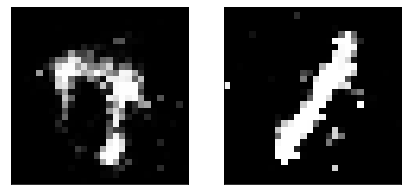

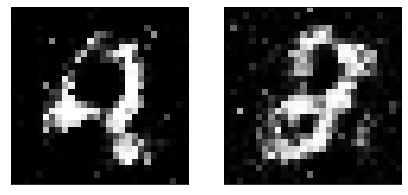

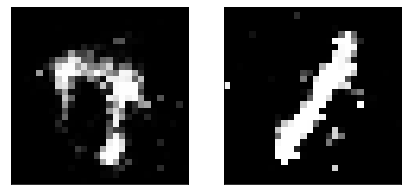

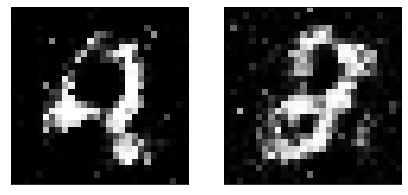

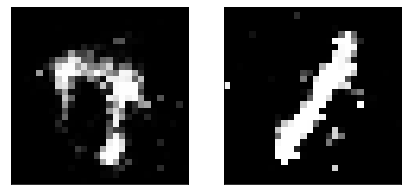

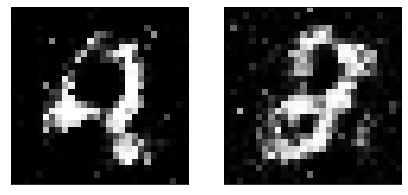

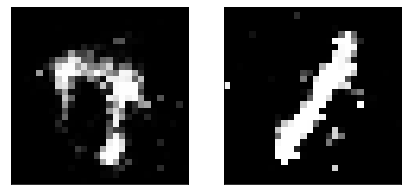

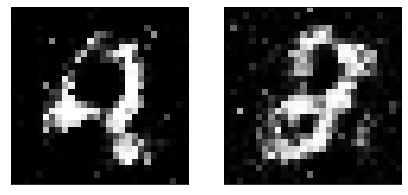

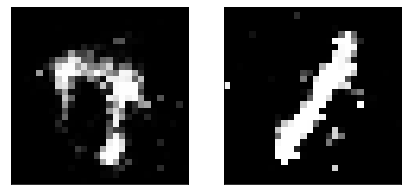

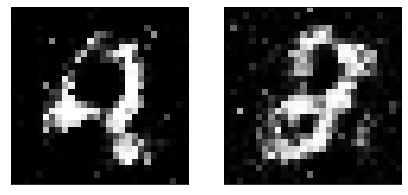

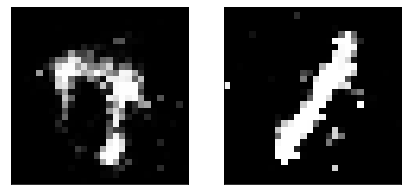

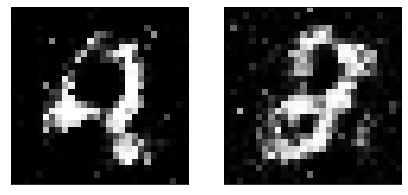

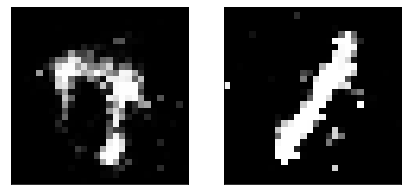

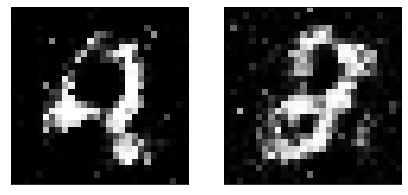

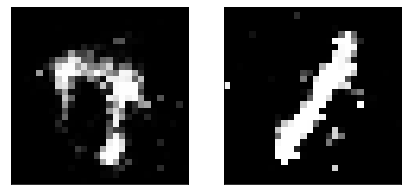

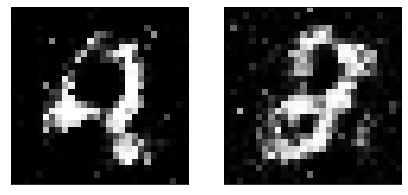

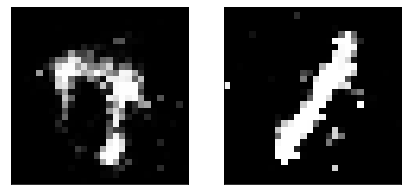

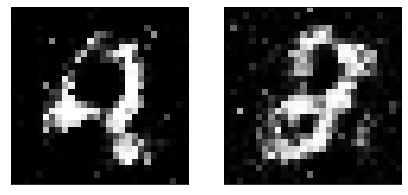

In [86]:
for i in range(1, epoch+1):
    view_samples(i, samples)
    view_samples(i, samples1)
    i+= 2

### Visualising Loss function

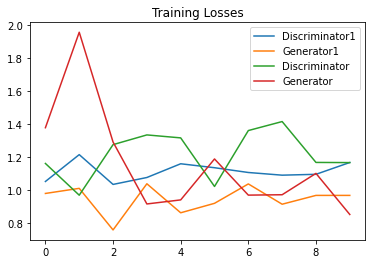

In [68]:
fig, ax = plt.subplots()
losses1 = np.array(losses1)
losses = np.array(losses)
plt.plot(losses1.T[0], label='Discriminator1')
plt.plot(losses1.T[1], label='Generator1')
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

### Result and Conclusion
Using a pretrained weight in GAN doesnt work same way as it works in classification tasks as extremal layer of Generator and Discriminator which should be learned during training are on the opposite side.
1. With the pretrained model we can see that the model has reached the minima of loss function has reached pretty fast, whereas when we trained the model it took some time to converge. 
2. When we freeze the weights of some layers then there is no sudden increase in jump of losses as it is not freeze version.

### Other Approaches 
1. We can try to train these extremal layer directly against each other, by by-passing all the intermediate layers as given in the paper "Mind2Mind : transfer learning for GANs"

2. Increasing a discriminator efficiency by extracting useful feature from tranfer learning like VGG pre-trianing network, this provides the discriminator with new training target, by this Discriminator can learn best features that can help it in distinguishing.